In [1]:
import pandas as pd

# Load the dataset
dataset = pd.read_csv("dataset/dataset.csv")

# Display the column names
dataset.columns


Index(['Date', 'Product ID', 'Sale Count', 'Inventory'], dtype='object')

In [2]:
# Convert the 'Date' column to datetime format
dataset['Date'] = pd.to_datetime(dataset['Date'])

# Extract the day of the week and assign it to the 'weekday' column
dataset['weekday'] = dataset['Date'].dt.day_name()
import holidays
# Assign 1 to the 'holiday' column for weekends and 0 otherwise
dataset['holiday'] = dataset['Date'].apply(lambda x: x in holidays.US()).astype(int)


# Drop the 'Sale Count' column
dataset.drop('Sale Count', axis=1, inplace=True)

# Display the modified dataset
dataset.head()


,Date,Product ID,Inventory,weekday,holiday
0,2023-06-18,Product_1,60,Sunday,0
1,2023-06-19,Product_1,56,Monday,1
2,2023-06-20,Product_1,52,Tuesday,0
3,2023-06-21,Product_1,48,Wednesday,0
4,2023-06-22,Product_1,44,Thursday,0


In [3]:
# Create lag features for 'Inventory' column
for i in range(1, 8):
    dataset[f'lag_{i}'] = dataset['Inventory'].shift(i)

# Drop rows with NaN values created due to lagging
dataset.dropna(inplace=True)

# Display the dataset with lag features
dataset.head()


,Date,Product ID,Inventory,weekday,holiday,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
7,2023-06-25,Product_1,32,Sunday,0,36.0,40.0,44.0,48.0,52.0,56.0,60.0
8,2023-06-26,Product_1,28,Monday,0,32.0,36.0,40.0,44.0,48.0,52.0,56.0
9,2023-06-27,Product_1,24,Tuesday,0,28.0,32.0,36.0,40.0,44.0,48.0,52.0
10,2023-06-28,Product_1,20,Wednesday,0,24.0,28.0,32.0,36.0,40.0,44.0,48.0
11,2023-06-29,Product_1,16,Thursday,0,20.0,24.0,28.0,32.0,36.0,40.0,44.0


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Encode the 'weekday' column
le = LabelEncoder()
dataset['weekday'] = le.fit_transform(dataset['weekday'])

# Define features and target variable
X = dataset.drop(['Date', 'Product ID', 'Inventory'], axis=1)
y = dataset['Inventory']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

X_train.shape, X_test.shape


((42, 9), (11, 9))

In [5]:
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb

# Initialize the models
ada = AdaBoostRegressor()
rf = RandomForestRegressor()
dt = DecisionTreeRegressor()
xgb_model = xgb.XGBRegressor()

# Fit the models on the training data
ada.fit(X_train, y_train)
rf.fit(X_train, y_train)
dt.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)

# Predict on the test data
predictions = {
    'AdaBoost': ada.predict(X_test),
    'Random Forest': rf.predict(X_test),
    'Decision Tree': dt.predict(X_test),
    'XGBoost': xgb_model.predict(X_test)
}

predictions


{'AdaBoost': array([52.        , 48.        , 44.        , 40.        , 36.        ,
        31.        , 28.        , 21.33333333, 18.        , 14.        ,
        12.        ]),
 'Random Forest': array([50.84, 47.04, 43.88, 40.96, 36.32, 31.72, 27.72, 24.08, 19.88,
        15.64, 12.48]),
 'Decision Tree': array([52., 48., 44., 40., 36., 32., 28., 24., 20., 16.,  4.]),
 'XGBoost': array([51.885185, 47.99973 , 43.99786 , 40.772297, 36.00876 , 31.999977,
        27.997871, 23.98999 , 20.00284 , 15.969786, 10.949571],
       dtype=float32)}

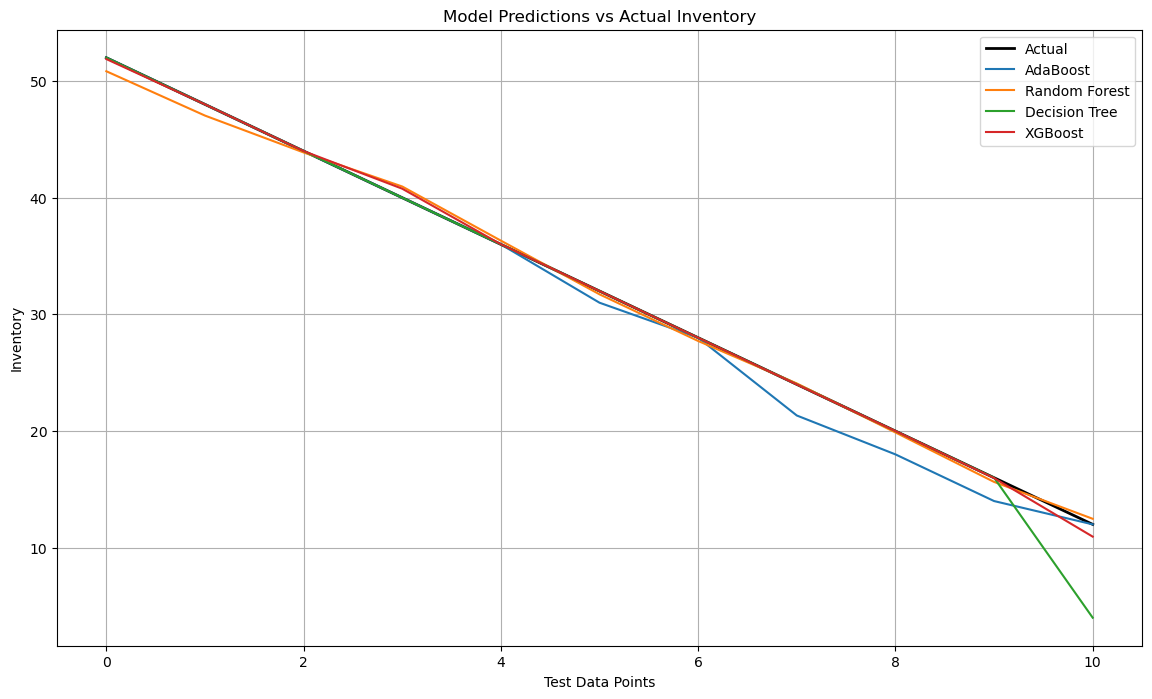

In [6]:
# Re-predicting with the other models to reconstruct the predictions dictionary
predictions = {
    'AdaBoost': ada.predict(X_test),
    'Random Forest': rf.predict(X_test),
    'Decision Tree': dt.predict(X_test),
    'XGBoost': xgb_model.predict(X_test)
}

# Now let's plot the predictions against the actual test data
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))

# Plotting actual values
plt.plot(y_test.values, label="Actual", color='black', linewidth=2)

# Plotting predictions for each model
for model_name, pred in predictions.items():
    plt.plot(pred, label=model_name)

plt.title("Model Predictions vs Actual Inventory")
plt.xlabel("Test Data Points")
plt.ylabel("Inventory")
plt.legend()
plt.grid(True)
plt.show()


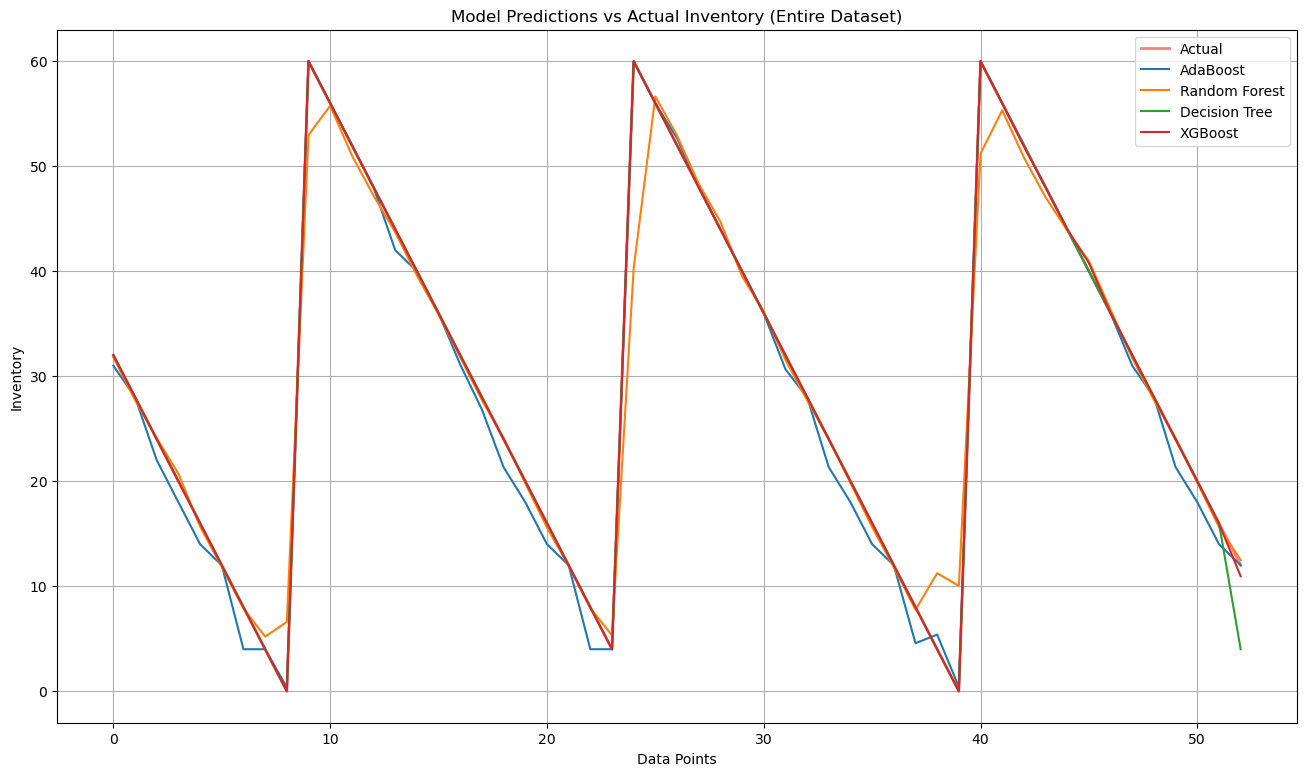

In [7]:
# Predicting on the entire dataset for each model
entire_predictions = {
    'AdaBoost': ada.predict(X),
    'Random Forest': rf.predict(X),
    'Decision Tree': dt.predict(X),
    'XGBoost': xgb_model.predict(X)
}

# Plotting on the entire dataset
plt.figure(figsize=(16, 9))

# Plotting actual values
plt.plot(dataset['Inventory'].values, label="Actual", color='red', linewidth=2,alpha=0.5)

# Plotting predictions for each model
for model_name, pred in entire_predictions.items():
    plt.plot(pred, label=model_name)

plt.title("Model Predictions vs Actual Inventory (Entire Dataset)")
plt.xlabel("Data Points")
plt.ylabel("Inventory")
plt.legend()
plt.grid(True)
plt.show()
